ver.0.3課題
pに応じたスコアリング：
http://www.w3.org/1999/02/22-rdf-syntax-ns#type →優先度下げる このリンクは非常に内容が薄い
pなし（自家リンク？）　→優先度下げる
http://dbpedia.org/ontology/wikiPageRedirects →Sにあれば優先度上げる？　Oにあればそちらで再検索でもいい
http://dbpedia.org/ontology/wikiPageRevisionID →意味なし　優先度かなり下げる
4回: ( ['http://xmlns.com/foaf/0.1/name', 'http://dbpedia.org/ontology/postalCode', 'http://dbpedia.org/ontology/commonName', 'http://dbpedia.org/ontology/purpose'] ) →優先度０に
3回: ( ['http://dbpedia.org/ontology/wikiPageExternalLink', 'http://xmlns.com/foaf/0.1/homepage', 'http://ja.dbpedia.org/property/外部リンク'] ) →優先度０に

大和ガス株式会社 ( ['http://xmlns.com/foaf/0.1/name', 'http://ja.dbpedia.org/property/社名', 'http://dbpedia.org/ontology/commonName'] )  →同義語

scoreに応じた深さのある探索
類義語をひとまとめに(同じような言葉が複数ならばないようにする)
same Asによる同義語の探索→実用的ではない

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 11.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=faa8479f63dc4aeb1fe2be034ae009b11cdb923846e7b5a84231efcd28223b1a
  Stored in directory: /Users/embryo03/Library/Caches/pip/wheels/91/8f/c2/83055ad0c9591b0a094730aa7cb2cc12fedacbcd2241baf534
S

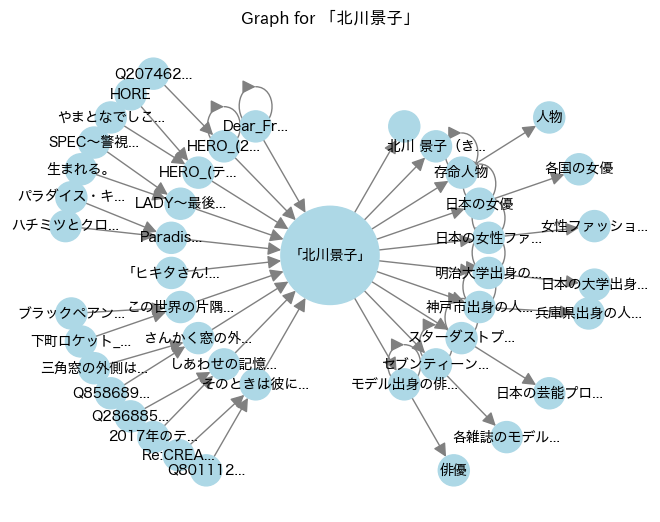

In [133]:
!pip install SPARQLWrapper
!pip install networkx
!pip install japanize-matplotlib
# !pip install matplotlib
from SPARQLWrapper import SPARQLWrapper
sparql = SPARQLWrapper(endpoint='http://ja.dbpedia.org/sparql', returnFormat='json')
input_name = input("Enter the name you want to search: ")
print("Searching for : ", input_name)
import networkx as nx 
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib



def get_results_for_subject(input):
    query_sentence_for_subject = "SELECT * where { ?s ?p <" + input + "> . }"
    sparql.setQuery(query_sentence_for_subject)
    results_for_subject = sparql.query().convert()
    # print("途中経過1 : ", results_for_subject)
    # print("途中経過2 : ", results_for_subject.keys())
    if "results" in results_for_subject.keys() and "bindings" in results_for_subject["results"].keys():
        return results_for_subject["results"]["bindings"]
    else:
        return []

def get_results_for_object(input):
    query_sentence_for_object = "SELECT * where { <" + input + "> ?p ?o . }"
    sparql.setQuery(query_sentence_for_object)
    results_for_object = sparql.query().convert()
    if "results" in results_for_object.keys() and "bindings" in results_for_object["results"].keys():
        return results_for_object["results"]["bindings"]
    else:
        return []

weight_list = [{"weight" : 0.9 , "p" : "http://www.w3.org/1999/02/22-rdf-syntax-ns#type" }, 
               {"weight" : 1 , "p" : "http://dbpedia.org/ontology/wikiPageWikiLink"} , 
               {"weight" : 0.1 , "p" : "http://xmlns.com/foaf/0.1/name"},
               {"weight" : 0.1 , "p" : "http://dbpedia.org/ontology/wikiPageRevisionID"},
               {"weight" : 0.1 , "p" : "http://dbpedia.org/ontology/commonName"},
               {"weight" : 0.1 , "p" : "http://dbpedia.org/ontology/postalCode"},
               {"weight" : 0.1 , "p" : "http://dbpedia.org/ontology/wikiPageExternalLink"},
               {"weight" : 0.1 , "p" : "http://ja.dbpedia.org/property/外部リンク"},
               {"weight" : 0.1 , "p" : 'http://dbpedia.org/ontology/wikiPageID'},
               {"weight" : 0.1 , "p" : "http://www.w3.org/2000/01/rdf-schema#label"},
               {"weight" : 0.1 , "p" : "http://www.w3.org/2004/02/skos/core#prefLabel"},
            #    {"weight" : 0.1 , "p" : "http://xmlns.com/foaf/0.1/name"},
            #    {"weight" : 0.1 , "p" : "http://xmlns.com/foaf/0.1/name"},
            #    {"weight" : 0.1 , "p" : "http://xmlns.com/foaf/0.1/name"},
            #    {"weight" : 0.1 , "p" : "http://xmlns.com/foaf/0.1/name"},
            #    {"weight" : 0.1 , "p" : "http://xmlns.com/foaf/0.1/name"},
            #    {"weight" : 0.1 , "p" : "http://xmlns.com/foaf/0.1/name"},
            #    {"weight" : 0.1 , "p" : "http://xmlns.com/foaf/0.1/name"},
]

def summarize_results_for_subject(results_for_subject, weight_list=weight_list , input_name=input_name):
    summary = []
    if results_for_subject == []:
        return []
    for binding in results_for_subject:
        new_item = {"value" : binding["s"]["value"] , "score" : 1 , "type" : "for_subject"}
        if new_item["value"] == input_name:
            # new_item["score"] = 0
            # new_item["path_list"] = ["None"]
            continue
        if new_item["value"].replace("Category:", "").replace("Template:", "") == input_name:
            continue
        elif "p" in binding.keys() and "value" in binding["p"].keys():
            new_item["path_list"] = [binding["p"]["value"]]
            if new_item["path_list"][0] in [item["p"] for item in weight_list]:
                for item in weight_list:
                    if item["p"] == new_item["path_list"][0]:
                        new_item["score"] = item["weight"]
        else:
            new_item["path_list"] = ["None"]
        if summary == []:
            summary.append(new_item)
        elif new_item["value"] in [item["value"] for item in summary]:
            for item in summary:
                if item["value"] == new_item["value"]:
                    # ここで重み付けをする
                    item["score"] += new_item["score"]
                    item["path_list"].append(new_item["path_list"][0])
        else:
            summary.append(new_item)
    sorted_summary = sorted(summary, key=lambda x:x["score"], reverse=True)
    return sorted_summary

def summarize_results_for_object(results_for_object , weight_list=weight_list , input_name=input_name):
    summary = []
    if results_for_object == []:
        return []
    for binding in results_for_object:
        new_item = {"value" : binding["o"]["value"], "score" : 1 , "type" : "for_object"}
        if new_item["value"] == input_name:
            # new_item["score"] = 0
            # new_item["path_list"] = ["None"]
            continue
        if new_item["value"].replace("Category:", "").replace("Template:", "") == input_name:
            continue
        elif "p" in binding.keys() and "value" in binding["p"].keys():
            new_item["path_list"] = [binding["p"]["value"]]
            if new_item["path_list"][0] in [item["p"] for item in weight_list]:
                for item in weight_list:
                    if item["p"] == new_item["path_list"][0]:
                        new_item["score"] = item["weight"]
        else:
            new_item["path_list"] = ["None"]
        if summary == []:
            summary.append(new_item)
        elif new_item["value"] in [item["value"] for item in summary]:
            for item in summary:
                if item["value"] == new_item["value"]:
                    # ここで重み付けをする
                    item["score"] += 1
                    item["path_list"].append(new_item["path_list"][0])
        else:
            summary.append(new_item)
    sorted_summary = sorted(summary, key=lambda x:x["score"], reverse=True)
    return sorted_summary


def draw_graph(summary_for_subject, summary_for_object, summary_for_subject_depth_2 = {}, summary_for_object_depth_2 = {} , input_name="「" + input_name + "」"):
    G = nx.DiGraph()
    G.add_node(input_name, type="input")
    pos={}
    pos[input_name] = (0, 0)
    node_size = {}
    node_size[input_name] = 5000
    number_for_subject = min(len(summary_for_subject), 10)
    number_for_object = min(len(summary_for_object), 10)




    for i in range(number_for_object):
        if len(summary_for_object[i]["value"].split("/")[-1].replace("Category:", "").replace("Template:", "")) < 7:
            label = summary_for_object[i]["value"].split("/")[-1].replace("Category:", "").replace("Template:", "")
        else:
            label = summary_for_object[i]["value"].split("/")[-1].replace("Category:", "").replace("Template:", "")[:7] + "..."
        # print("label O : ", label)
        G.add_node(label)
        G.add_edge(input_name, label)
        # edge_weights.append(summary_for_object[i]["score"] * 10)
        # pos[label] = (0.3 * math.sin(1 * np.pi * (i+2) / (3 + number_for_object)), 0.3 * math.cos(1 * np.pi * (i+2) / (3 + number_for_object)))
        node_size[label] = 500
        if summary_for_object_depth_2 != {} and summary_for_object[i]["value"] in summary_for_object_depth_2.keys():
            if summary_for_object_depth_2[summary_for_object[i]["value"]] != []:
                number_for_object_depth_2 = min(len(summary_for_object_depth_2[summary_for_object[i]["value"]]), 2)
                for j in range(number_for_object_depth_2):
                    if len(summary_for_object_depth_2[summary_for_object[i]["value"]][j]["value"].split("/")[-1].replace("Category:", "").replace("Template:", "")) < 7:
                        label_d2 = summary_for_object_depth_2[summary_for_object[i]["value"]][j]["value"].split("/")[-1].replace("Category:", "").replace("Template:", "")
                    else:
                        label_d2 = summary_for_object_depth_2[summary_for_object[i]["value"]][j]["value"].split("/")[-1].replace("Category:", "").replace("Template:", "")[:7] + "..."
                    # print("label O2 : ", label_d2)
                    G.add_node(label_d2)
                    G.add_edge(label, label_d2)
                    # edge_weights.append(summary_for_object[i]["score"] * 10)
                    pos[label_d2] = (0.5 * math.sin(0.5 * np.pi * (2*i+j+3) / (3 + number_for_object)), 0.5 * math.cos(0.5 * np.pi * (2*i+j+3) / (3 + number_for_object)))
                    node_size[label_d2] = 500
        pos[label] = (0.3 * math.sin(1 * np.pi * (i+2) / (3 + number_for_object)), 0.3 * math.cos(1 * np.pi * (i+2) / (3 + number_for_object)))


    for i in range(number_for_subject):
        if len(summary_for_subject[i]["value"].split("/")[-1].replace("Category:", "").replace("Template:", "")) < 7:
            label = summary_for_subject[i]["value"].split("/")[-1].replace("Category:", "").replace("Template:", "")
        else:
            label = summary_for_subject[i]["value"].split("/")[-1].replace("Category:", "").replace("Template:", "")[:7] + "..."
        # print("label S : ", label)
        G.add_node(label)
        G.add_edge(label , input_name)
        # pos[label] = (0.3 * math.sin(-1 * np.pi * (i+2) / (3 + number_for_subject)), 0.3 * math.cos(1 * np.pi * (i+2) / (3 + number_for_subject)))
        node_size[label] = 500
        if summary_for_subject_depth_2 != {} and summary_for_subject[i]["value"] in summary_for_subject_depth_2.keys():
            if summary_for_subject_depth_2[summary_for_subject[i]["value"]] != []:
                number_for_subject_depth_2 = min(len(summary_for_subject_depth_2[summary_for_subject[i]["value"]]), 2)
                for j in range(number_for_subject_depth_2):
                    if len(summary_for_subject_depth_2[summary_for_subject[i]["value"]][j]["value"].split("/")[-1].replace("Category:", "").replace("Template:", "")) < 7:
                        label_d2 = summary_for_subject_depth_2[summary_for_subject[i]["value"]][j]["value"].split("/")[-1].replace("Category:", "").replace("Template:", "")
                    else:
                        label_d2 = summary_for_subject_depth_2[summary_for_subject[i]["value"]][j]["value"].split("/")[-1].replace("Category:", "").replace("Template:", "")[:7] + "..."
                    # print("label S2 : ", label_d2)
                    G.add_node(label_d2)
                    G.add_edge(label_d2, label)
                    # edge_weights.append(summary_for_object[i]["score"] * 10)
                    pos[label_d2] = (0.5 * math.sin(-0.5 * np.pi * (2*i+j+3) / (3 + number_for_subject)), 0.5 * math.cos(0.5 * np.pi * (2*i+j+3) / (3 + number_for_subject)))
                    node_size[label_d2] = 500
        pos[label] = (0.3 * math.sin(-1 * np.pi * (i+2) / (3 + number_for_subject)), 0.3 * math.cos(1 * np.pi * (i+2) / (3 + number_for_subject)))

    # print(G)
    # pos[input_name] = (0, 0)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", font_family='Hiragino Sans' ,arrowsize=20, edge_color="gray", node_size=[v for v in node_size.values()],font_size=10)
    plt.title("Graph for " + input_name)
    plt.show()

    # nx.draw_networkx_nodes(G, pos, node_color="b", node_size=1000)
    # nx.draw_networkx_edges(G, pos, width=edge_weights)
    # # nx.draw_networkx_labels(G, pos)
    # nx.draw_networkx_labels(G,pos,font_size=10,font_family='Hiragino Sans')
    # plt.title("Graph for " + input_name)
    # plt.show()
    
    

print("Searching for the 1st depth of the graph : " + input_name)
results_for_subject = get_results_for_subject("http://ja.dbpedia.org/resource/" + input_name)
results_for_object = get_results_for_object("http://ja.dbpedia.org/resource/" + input_name)
summary_for_subject = summarize_results_for_subject(results_for_subject)
summary_for_object = summarize_results_for_object(results_for_object)
print("Results_for_subject for the 1st depth of the graph : ", results_for_subject)
print("Results_for_object for the 1st depth of the graph : ", results_for_object)
print("Summary_for_subject for the 1st depth of the graph : ", summary_for_subject)
print("Summary_for_object for the 1st depth of the graph : ", summary_for_object)
#10 items of first depth に対して、それぞれのitemに対して、さらに深い階層を探索する
results_for_object_depth_2 = {}
results_for_subject_depth_2 = {}
summary_for_subject_depth_2 = {}
summary_for_object_depth_2 = {}
if summary_for_subject != [] and len(summary_for_subject) > 10:
    for item in summary_for_subject[:10]:
        if item["value"] == input_name:
            continue
        if len(item["value"].split("/")[-1].replace("Category:", "").replace("Template:", "")) > 20:
            continue
        # print ("item : ", item)
        results_for_subject_depth_2[item["value"]] = get_results_for_subject(item["value"])
        summary_for_subject_depth_2[item["value"]] = summarize_results_for_subject(results_for_subject_depth_2[item["value"]], input_name=item["value"])
        # print("Results_for_subject for the 2nd depth of the graph : ", len(summary_for_subject_depth_2[item["value"]]) , summary_for_subject_depth_2[item["value"]])

if summary_for_object != [] and len(summary_for_object) > 10:
    for item in summary_for_object[:10]:
        if item["value"] == input_name:
            continue
        if len(item["value"].split("/")[-1].replace("Category:", "").replace("Template:", "")) > 20:
            continue
        # print ("item : ", item)
        results_for_object_depth_2[item["value"]] = get_results_for_object(item["value"])
        summary_for_object_depth_2[item["value"]] = summarize_results_for_object(results_for_object_depth_2[item["value"]], input_name=item["value"])
        # print("Results_for_object for the 2nd depth of the graph : ", len(summary_for_object_depth_2[item["value"]]) , summary_for_object_depth_2[item["value"]])

        

# ここでグラフを描画する
draw_graph(summary_for_subject, summary_for_object , summary_for_subject_depth_2 , summary_for_object_depth_2)



